Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [2]:
batch_size = 64
learning_rate = 1e-3
num_epochs = 100
latent_dim = 7
mnist_class_anomaly = 1
kernels = 2
#fuzzy_rules_count = 3*5
beta = 1e-3
#gamma = 1

prefix = f"fuzzy_cvae_mamdani_anomaly"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 7, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [3]:
def norm_and_transform(x):
    nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(nimg, -1, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomCrop(size=26),
    transforms.Resize(size=(28, 28)),
    transforms.Lambda(norm_and_transform)
])

In [4]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

53258

загружаем тестовую выборку

In [5]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [6]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

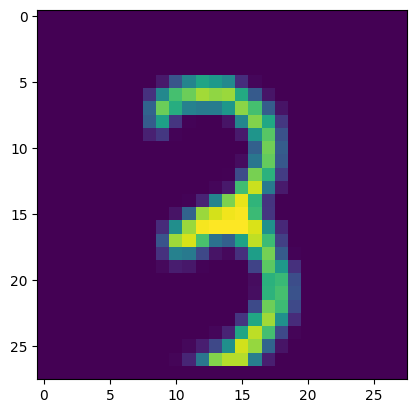

In [7]:
for data,_ in iter(train_loader):
    plt.imshow(data[0].squeeze())
    
    break

## Модель

Модель представляет собой VAE с набором дополнительного инференса над латентным слоем для предсказания ошибки реконструкции

In [8]:
# basic resdidual block of ResNet
# This is generic in the sense, it could be used for downsampling of features.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=[1, 1], downsample=None):
        """
        A basic residual block of ResNet
        Parameters
        ----------
            in_channels: Number of channels that the input have
            out_channels: Number of channels that the output have
            stride: strides in convolutional layers
            downsample: A callable to be applied before addition of residual mapping
        """
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride[0], 
            padding=1, bias=False
        )

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=stride[1], 
            padding=1, bias=False
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        # applying a downsample function before adding it to the output
        if(self.downsample is not None):
            residual = downsample(residual)

        out = F.relu(self.bn(self.conv1(x)))
        
        out = self.bn(self.conv2(out))
        # note that adding residual before activation 
        out = out + residual
        out = F.relu(out)
        return out

In [9]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.input = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size=3, padding=2, stride=1),
            nn.BatchNorm2d(kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(kernels, 2*kernels, kernel_size=2, stride=2, padding = 2),
            nn.BatchNorm2d(2*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(2*kernels, 2*kernels, kernel_size=3, stride=2, padding = 2),
            nn.BatchNorm2d(2*kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(4*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(4*kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 4, stride=1, padding = 0),
            nn.BatchNorm2d(8*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(8*kernels, 8*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(8*kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*kernels, 2 * latent_dim), # mean + variance.
        )

        self.downscale_1 = nn.Conv2d(kernels, 8*kernels, kernel_size=30)
        self.downscale_2 = nn.Conv2d(2*kernels, 8*kernels, kernel_size=10)
        self.downscale_3 = nn.Conv2d(4*kernels, 8*kernels, kernel_size=6)
        self.after_sum = nn.SiLU()
        
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.input(x)
        #print(x.shape)
        res_1 = self.downscale_1(x)
        

        x = self.block_2(x)
        #print(x.shape)
        res_2 = self.downscale_2(x)
        
        x = self.block_3(x)
        #print(x.shape)
        res_3 = self.downscale_3(x)
        
        x = self.block_4(x)

        x = self.after_sum(x + res_1 + res_2 + res_3)
        x = self.out(x)

        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [10]:
inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim)
mu = m.forward(inp)
mu[0].shape

torch.Size([10, 7])

In [11]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        self.inp = nn.Sequential(
            nn.Linear(latent_dim, 8*kernels),
            nn.SiLU(), 
            nn.BatchNorm1d(8*kernels, track_running_stats=False),
            nn.Unflatten(1, (8*kernels, 1, 1)),
        )

        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(8*kernels, 4*kernels, kernel_size = 4, stride=1, padding = 0),
            nn.BatchNorm2d(4*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.ConvTranspose2d(4*kernels, 4*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(4*kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(4*kernels, 2*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(2*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.ConvTranspose2d(2*kernels, 2*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(2*kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(2*kernels, kernels, kernel_size=3, stride=2, padding = 2),
            nn.BatchNorm2d(kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.ConvTranspose2d(kernels, kernels, kernel_size=2, stride=2, padding = 2),
            nn.BatchNorm2d(kernels, track_running_stats=False),
            nn.SiLU(),     
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(kernels, 1, kernel_size=3, padding=2, stride=1),
            nn.Tanh(),  
        )

        self.upscale_1 = nn.ConvTranspose2d(8*kernels, 4*kernels, kernel_size=6)
        self.upscale_2 = nn.ConvTranspose2d(8*kernels, 2*kernels, kernel_size=10)
        self.upscale_3 = nn.ConvTranspose2d(8*kernels,   kernels, kernel_size=30)
        self.after_sum = nn.SiLU()
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.inp(z)
        res_1 = self.upscale_1(x)
        res_2 = self.upscale_2(x)
        res_3 = self.upscale_3(x)

        x = self.block_1(x)
        x = self.after_sum(x + res_1)

        x = self.block_2(x)
        x = self.after_sum(x + res_2)

        x = self.block_3(x)
        x = self.after_sum(x + res_3)
        
        x = self.decoder(x)
        
        return x

In [12]:
inp = torch.rand(10, latent_dim)
m = Decoder(latent_dim)
mu = m.forward(inp)
mu.shape

torch.Size([10, 1, 28, 28])

In [13]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        #initial_centroids = np.random.rand(fuzzy_rules_count, latent_dim)
        #initial_scales = 1e-2 * np.ones((fuzzy_rules_count, latent_dim))
        # self.fuzzy = nn.Sequential(
        #     FuzzyBellLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True),
        #     DefuzzyLinearLayer.from_array(np.repeat([1.0,  0.0, -1.0], fuzzy_rules_count/3).reshape(1, -1), with_norm=False, trainable=False)
        # )

    def forward(self, x):
        """
        
        """
        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        #fz = self.fuzzy(mu)
        
        return mu, x_recon#, fz.squeeze()
    
    def half_pass(self, x):
        """
        
        """
        mu, logvar, z = self.encoder(x)
        #fz = self.fuzzy(mu)
        return mu, logvar, z#, fz.squeeze()
    
    def decoder_pass(self, x):
        return self.decoder(x)


## Обучение

In [14]:
model = VAE(latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 88,907


VAE(
  (encoder): Encoder(
    (input): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): SiLU()
    )
    (block_2): Sequential(
      (0): Conv2d(2, 4, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): SiLU()
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): SiLU()
    )
    (block_3): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): SiLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): S

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [16]:
def compute_loss(x, recon_x, mu, logvar):
    
    diff = ssim((x + 1)/2, (recon_x+1)/2)
    #fz_loss = (diff - fz).square().mean() #

    loss_recon = (1 - diff).abs().mean() #F.binary_cross_entropy((recon_x+1)/2, (x + 1)/2, reduction='none').sum(-1).mean()#
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
    
    loss = loss_recon + beta * loss_kl #+ gamma * fz_loss

    return loss, loss_recon, loss_kl
    

In [17]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [18]:
# inp = (torch.rand((10, 1, 28, 28))).to(device)
# mu, logvar, z, fz = model.half_pass(inp)
# recon_x = model.decoder_pass(z)
# mu2,_,_,_ = model.half_pass(recon_x)
# loss, loss_recon, loss_kl, fz_loss = compute_loss(inp, recon_x, mu, logvar, fz)
# fz_loss

In [19]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logvar, z = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        
        loss, _, _ = compute_loss(data, recon_x, mu, logvar)
        
        #ev_loss = keep_eigenvals_positive_loss(model.fuzzy[0])
        #if ev_loss.item() > 0:
        #    loss.backward(retain_graph=True)
        #    ev_loss.backward()
        #else:
        loss.backward()
                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [20]:
def get_arate(inp):
    mu, _, _ = model.half_pass(inp)
    prev_mu = mu
    sum = torch.zeros_like(mu)
    
    for i in range(10):
        recon_x = model.decoder_pass(mu)
        mu, _, _ = model.half_pass(recon_x)
        sum += (mu - prev_mu).abs()
        prev_mu = mu
        
    return sum.sum(-1).cpu().numpy()

In [21]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_recon_loss = 0
    test_kl_loss = 0
    #test_fz_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)

    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            mu, logvar, z = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            
            _, loss_recon, loss_kl = compute_loss(data, recon_x, mu, logvar)
                    
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            #test_fz_loss += fz_loss.item()

    
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    #test_fz_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} AUC {roc_auc:.4f}')
    
    if writer is not None:
        
        writer.add_scalar('ADFVAE/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('ADFVAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/KLD', test_kl_loss, global_step=cur_step)
        #writer.add_scalar('ADFVAE/Fuzzy', test_fz_loss, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('ADFVAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [22]:
prev_updates = 0

In [23]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)
    scheduler.step()


[833] Reconstruction loss: 0.3957, KLD: 11.8776 AUC 0.5552
[1666] Reconstruction loss: 0.3724, KLD: 11.7024 AUC 0.5733
[2499] Reconstruction loss: 0.3664, KLD: 11.1966 AUC 0.5071
[3332] Reconstruction loss: 0.3571, KLD: 11.0195 AUC 0.4657
[4165] Reconstruction loss: 0.3542, KLD: 11.0552 AUC 0.5053
[4998] Reconstruction loss: 0.3533, KLD: 11.3766 AUC 0.4926
[5831] Reconstruction loss: 0.3519, KLD: 11.0466 AUC 0.5889
[6664] Reconstruction loss: 0.3490, KLD: 11.0232 AUC 0.6108
[7497] Reconstruction loss: 0.3435, KLD: 11.3547 AUC 0.6113
[8330] Reconstruction loss: 0.3392, KLD: 11.1372 AUC 0.5033
[9163] Reconstruction loss: 0.3337, KLD: 11.4933 AUC 0.6346
[9996] Reconstruction loss: 0.3304, KLD: 11.4981 AUC 0.5348
[10829] Reconstruction loss: 0.3339, KLD: 11.3477 AUC 0.4700
[11662] Reconstruction loss: 0.3293, KLD: 11.3467 AUC 0.5343
[12495] Reconstruction loss: 0.3257, KLD: 11.7243 AUC 0.6037
[13328] Reconstruction loss: 0.3314, KLD: 11.3712 AUC 0.5736
[14161] Reconstruction loss: 0.3366, 

## Визуализируем результаты

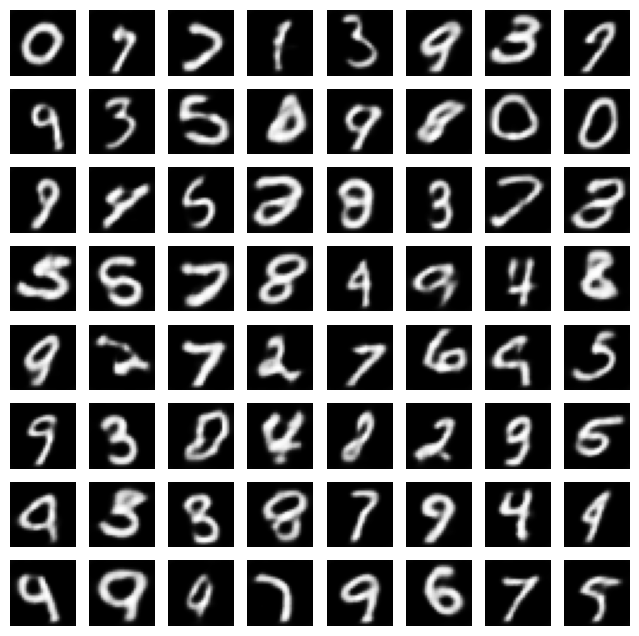

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

MNIST HIST:   0%|          | 0/157 [00:00<?, ?it/s]

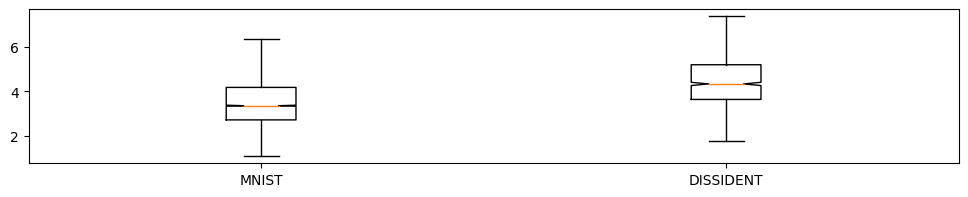

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

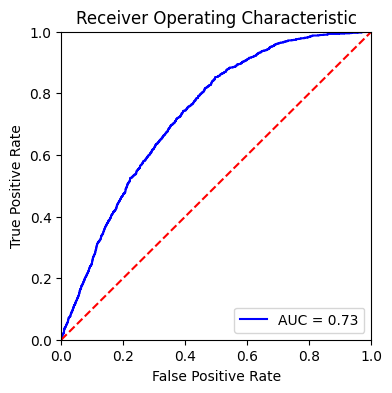

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

Encoding:   0%|          | 0/157 [00:00<?, ?it/s]

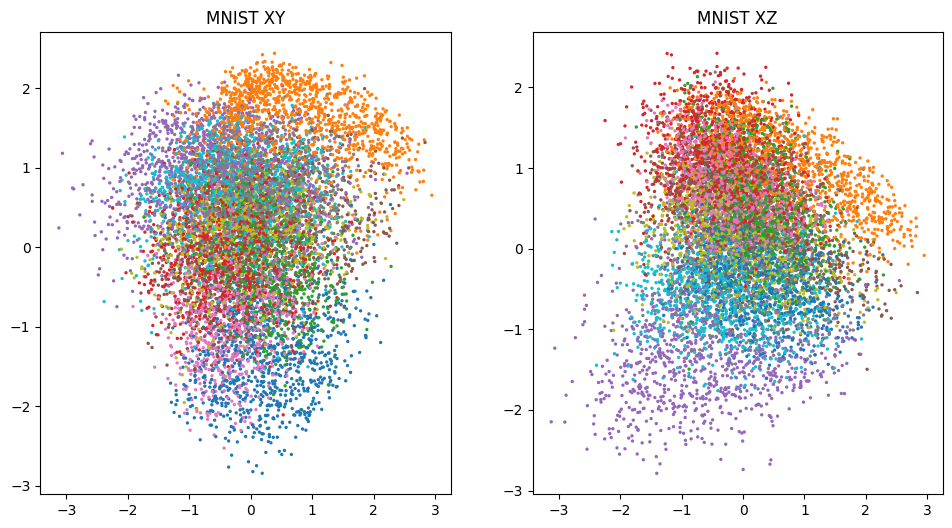

In [ ]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding,_ = model.forward(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

plt.figure(figsize=(18, 6))

R, C = 1, 3

plt.subplot(R, C, 1)
plt.title("MNIST XY")
plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.subplot(R, C, 2)
plt.title("MNIST XZ")
plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)


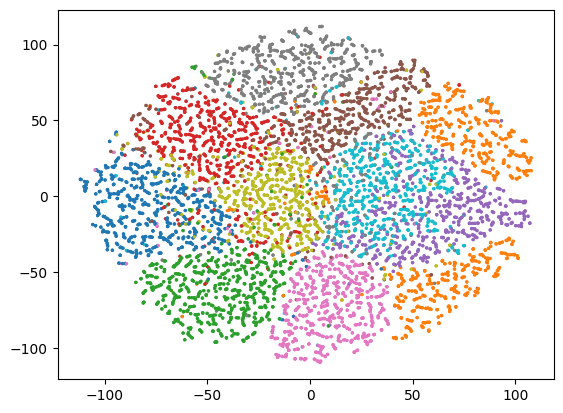

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embedings)
plt.scatter(X_embedded[:, 0],      X_embedded[:,  1], c=labels_expected, cmap='tab10', s=2)

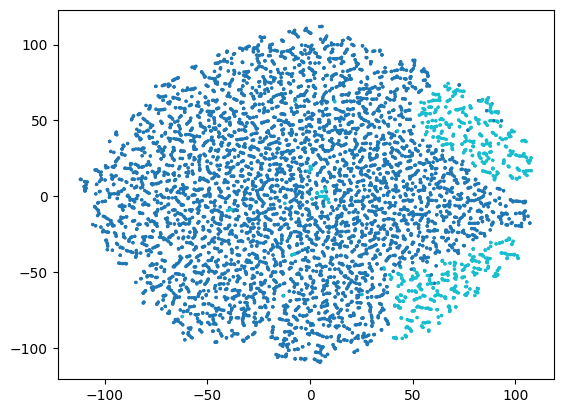

In [ ]:
plt.scatter(X_embedded[:, 0],      X_embedded[:,  1], c=[a == mnist_class_anomaly for a in labels_expected] , cmap='tab10', s=2)